Generating phase diagram... This may take a moment.
Completed K_max: 0.10
Completed K_max: 0.30
Completed K_max: 0.51
Completed K_max: 0.71
Completed K_max: 0.92
Completed K_max: 1.12
Completed K_max: 1.33
Completed K_max: 1.53
Completed K_max: 1.73
Completed K_max: 1.94
Completed K_max: 2.14
Completed K_max: 2.35
Completed K_max: 2.55
Completed K_max: 2.75
Completed K_max: 2.96
Completed K_max: 3.16
Completed K_max: 3.37
Completed K_max: 3.57
Completed K_max: 3.78
Completed K_max: 3.98
Completed K_max: 4.18
Completed K_max: 4.39
Completed K_max: 4.59
Completed K_max: 4.80
Completed K_max: 5.00


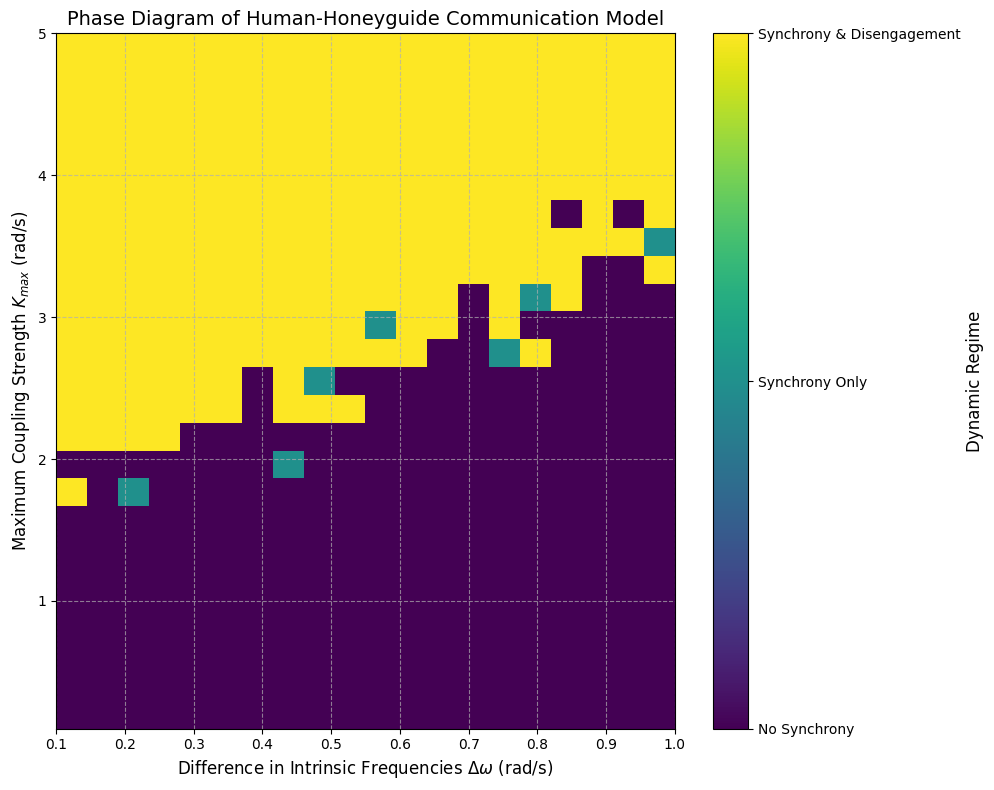


Parameter ranges for 'Synchrony & Disengagement' (Phase 2):
  Delta_w: [0.10, 1.00] rad/s
  K_max:   [1.73, 5.00] rad/s


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def run_simulation(
    delta_w, K_max, beta, delta, r, alpha, G, thresh_cos, tau_sacc,
    T_sync_duration, noise_strength_base, noise_strength_high,
    dt, T, disengagement_check_window
):
    """
    Runs a single simulation of the human-honeyguide communication model
    and classifies its dynamic outcome.

    Args:
        delta_w (float): Difference in intrinsic frequencies (rad/s).
        K_max (float): Maximum coupling strength (rad/s).
        beta (float): Growth rate for K.
        delta (float): Decay rate for K.
        r (float): Growth rate for x.
        alpha (float): Modulation strength on x dynamics.
        G (float): Gain for the accumulated signal.
        thresh_cos (float): Threshold for the cosine term (dimensionless).
        tau_sacc (float): Time constant for the decay of S_acc (s).
        T_sync_duration (float): Required duration of synchrony to trigger exit (s).
        noise_strength_base (float): Standard noise level during interaction.
        noise_strength_high (float): High noise level to break synchrony lock.
        dt (float): Time step (s).
        T (float): Total simulation time (s).
        disengagement_check_window (float): Time window (in seconds) after exit_time
                                            to check for disengagement.

    Returns:
        int: Classification of the dynamic regime:
             0: No Synchrony
             1: Synchrony Only (Engagement, but no clear disengagement)
             2: Synchrony & Disengagement (Engagement followed by disengagement)
    """
    n_steps = int(T / dt)
    time = np.linspace(0, T, n_steps)

    phi = np.zeros(n_steps)
    x = np.zeros(n_steps)
    K = np.zeros(n_steps)
    S_acc = np.zeros(n_steps)

    # Initial conditions: Random phase difference, low participation, low coupling, no accumulated signal
    phi[0] = np.pi * (2 * np.random.rand() - 1)
    x[0] = 0.01
    K[0] = 0.1
    S_acc[0] = 0.0

    sync_time_accumulator = 0.0
    exit_triggered = False
    exit_time = -1
    current_noise_strength = noise_strength_base
    
    # Flag to track if the system ever entered sustained synchrony
    entered_sustained_synchrony = False

    for t_idx in range(n_steps - 1):
        # Check for instantaneous synchrony condition (cosine of phase difference above threshold)
        if np.cos(phi[t_idx]) > thresh_cos:
            sync_time_accumulator += dt
        else:
            sync_time_accumulator = 0 # Reset if synchrony is broken

        # If sustained synchrony duration is met and exit hasn't been triggered yet
        if sync_time_accumulator >= T_sync_duration and not exit_triggered:
            exit_triggered = True
            current_noise_strength = noise_strength_high # Increase noise to attempt disengagement
            exit_time = time[t_idx] # Record the time of exit trigger
            entered_sustained_synchrony = True # Mark that sustained synchrony was achieved

        # Euler-Maruyama integration for the differential equations
        # d(phi)/dt = delta_w - 2*K*sin(phi) + noise
        dphi_dt = delta_w - 2 * K[t_idx] * np.sin(phi[t_idx])
        
        # d(x)/dt = r*S_acc*x*(1-x)*(1 + alpha*cos(phi))
        dx_dt = r * S_acc[t_idx] * x[t_idx] * (1 - x[t_idx]) * (1 + alpha * np.cos(phi[t_idx]))
        
        # d(K)/dt = beta*x*cos(phi)*(K_max - K) - delta*K
        dK_dt = beta * x[t_idx] * np.cos(phi[t_idx]) * (K_max - K[t_idx]) - delta * K[t_idx]
        
        # d(S_acc)/dt = G*max(0, cos(phi) - thresh_cos)*x - S_acc/tau_sacc
        max_term = np.maximum(0, np.cos(phi[t_idx]) - thresh_cos)
        dS_acc_dt = G * max_term * x[t_idx] - (S_acc[t_idx] / tau_sacc)

        # Add stochastic noise to phase dynamics
        noise = current_noise_strength * np.random.randn() * np.sqrt(dt)
        phi[t_idx+1] = phi[t_idx] + dt * dphi_dt + noise
        phi[t_idx+1] = (phi[t_idx+1] + np.pi) % (2 * np.pi) - np.pi # Keep phi within [-pi, pi]
            
        # Update other state variables
        x[t_idx+1] = x[t_idx] + dt * dx_dt
        K[t_idx+1] = K[t_idx] + dt * dK_dt
        S_acc[t_idx+1] = S_acc[t_idx] + dt * dS_acc_dt
        
        # Apply physical constraints (clipping values to valid ranges)
        x[t_idx+1] = np.clip(x[t_idx+1], 0, 1) # Participation x is between 0 and 1
        K[t_idx+1] = np.clip(K[t_idx+1], 0, K_max) # Coupling strength K is between 0 and K_max
        S_acc[t_idx+1] = np.maximum(0, S_acc[t_idx+1]) # Accumulated signal S_acc is non-negative

    # Classification Logic for Dynamic Regimes
    # 0: No Synchrony
    # 1: Synchrony Only (Engagement achieved, but no clear disengagement after noise increase)
    # 2: Synchrony & Disengagement (Engagement achieved, followed by disengagement)

    if not entered_sustained_synchrony:
        return 0 # The system never entered a sustained synchronous state

    # If sustained synchrony was achieved, check if disengagement occurred
    if exit_triggered:
        # Determine the starting index for checking disengagement
        # We add a buffer (disengagement_check_window) after exit_time to allow for transients
        check_start_time = exit_time + disengagement_check_window
        check_start_idx = int(check_start_time / dt)
        
        # Ensure the check window is within simulation bounds
        if check_start_idx < n_steps:
            phi_after_exit = phi[check_start_idx:]
            
            # Use standard deviation of phi to detect disengagement (wide fluctuations)
            # A standard deviation greater than pi/4 (approx 0.785 rad) indicates significant phase variability
            if np.std(phi_after_exit) > np.pi / 4: 
                return 2 # Synchrony & Disengagement: Phase became unsynchronized after the exit trigger
            else:
                return 1 # Synchrony Only: Noise increased, but synchrony was maintained or disengagement was incomplete
        else:
            return 1 # Synchrony Only: Simulation ended too soon after the exit trigger to properly assess disengagement
    else:
        return 1 # Synchrony Only: Synchrony was achieved, but the exit condition (T_sync_duration) was never met

# Fixed parameters for the model 
fixed_params = {
    "beta": 0.5,
    "delta": 0.1,
    "r": 1.0,
    "alpha": 1.0,
    "G": 1.0,
    "thresh_cos": 0.75,
    "tau_sacc": 10.0,
    "T_sync_duration": 150.0,
    "noise_strength_base": 0.5,
    "noise_strength_high": 3.0,
    "dt": 0.01,
    "T": 600, #800
    "disengagement_check_window": 50 # Window (in seconds) after exit_time to check for disengagement
}

# Parameters to vary for the phase diagram
# These ranges are chosen to explore different behaviors around the original model's parameters
delta_w_values = np.linspace(0.1, 1.0, 20) # Range for difference in intrinsic frequencies
K_max_values = np.linspace(0.1, 5.0, 25)  # Range for maximum coupling strength

# Initialize a 2D array to store the classification results for each parameter combination
phase_diagram_results = np.zeros((len(K_max_values), len(delta_w_values)))

# Run simulations across the parameter space
print("Generating phase diagram... This may take a moment.")
for i, K_max_val in enumerate(K_max_values):
    for j, delta_w_val in enumerate(delta_w_values):
        # Run the simulation with the current parameter combination
        result = run_simulation(
            delta_w=delta_w_val,
            K_max=K_max_val,
            **fixed_params # Unpack the rest of the fixed parameters
        )
        phase_diagram_results[i, j] = result
    # print progress
    print(f"Completed K_max: {K_max_val:.2f}")

# Plotting the Phase Diagram 
plt.figure(figsize=(10, 8)) # Set figure size for better readability
plt.imshow(
    phase_diagram_results,
    origin='lower', # Ensures that the lowest K_max and delta_w values are at the bottom-left
    extent=[delta_w_values.min(), delta_w_values.max(), K_max_values.min(), K_max_values.max()],
    aspect='auto', # Adjusts aspect ratio automatically
    cmap='viridis', # Colormap to visualize different regimes (e.g., 'viridis', 'RdYlGn', 'coolwarm')
    interpolation='nearest' # Use nearest-neighbor interpolation for discrete values
)

# Create a custom colorbar to explain the dynamic regimes
cbar = plt.colorbar(ticks=[0, 1, 2])
cbar.set_label('Dynamic Regime', fontsize=12)
cbar.set_ticklabels(['No Synchrony', 'Synchrony Only', 'Synchrony & Disengagement'])

plt.xlabel('Difference in Intrinsic Frequencies $\\Delta\\omega$ (rad/s)', fontsize=12)
plt.ylabel('Maximum Coupling Strength $K_{max}$ (rad/s)', fontsize=12)
plt.title('Phase Diagram of Human-Honeyguide Communication Model', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Identify and print parameter ranges for 'Synchrony & Disengagement' (Phase 2) 
sd_indices = np.where(phase_diagram_results == 2) # Find all (row, col) indices where the result is 2
if len(sd_indices[0]) > 0: # Check if Phase 2 was found at all
    min_delta_w_sd = delta_w_values[sd_indices[1]].min()
    max_delta_w_sd = delta_w_values[sd_indices[1]].max()
    min_K_max_sd = K_max_values[sd_indices[0]].min()
    max_K_max_sd = K_max_values[sd_indices[0]].max()
    
    print(f"\nParameter ranges for 'Synchrony & Disengagement' (Phase 2):")
    print(f"  Delta_w: [{min_delta_w_sd:.2f}, {max_delta_w_sd:.2f}] rad/s")
    print(f"  K_max:   [{min_K_max_sd:.2f}, {max_K_max_sd:.2f}] rad/s")
else:
    print("\n'Synchrony & Disengagement' (Phase 2) not found in the explored parameter space.")